In [44]:
import os
import glob
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import util
import run_model
import pure_tone_dataset


In [45]:
torch.manual_seed(1)

interval_list = [-0.5]
f_list = [250]
dataset = pure_tone_dataset.Dataset(
    sr=40e3,
    dur=0.200,
    dur_ramp=0.020,
    dur_padded=0.250,
    f_min=2e2,
    f_max=1e4,
    f_list=f_list,
    interval_min=1e-5,
    interval_max=1e-0,
    interval_list=interval_list,
    dbspl_min=37.0,
    dbspl_max=43.0,
    dbspl_fixed=False,
    phase_fixed=0.0,
)

example = dataset[0]
x0 = example.pop("x0")
x1 = example.pop("x1")
x = torch.stack([x0, x1], dim=1)[None, ...]
print("f1={:.2f}, f2={:2f}, dbspl1={:.2f}, dbspl2={:.2f}".format(example["f0"], example["f1"], example["dbspl0"], example["dbspl1"]))


f1=250.00, f2=176.776695, dbspl1=41.55, dbspl2=38.68


In [46]:
dir_model = "models/freq_quarter_octave/0250hz/IHC3000/arch_0346_0000"
with open(os.path.join(dir_model, "config.json"), "r") as f:
    config_model = json.load(f)
with open(os.path.join(dir_model, "arch.json"), "r") as f:
    architecture = json.load(f)
model = run_model.Model(
    config_model=config_model,
    architecture=architecture,
)


In [47]:
model.eval()
y = model.peripheral_model(x)
z = y.clone()
layer_list = []
for name, layer in model.perceptual_model.body.named_children():
    z = layer(z)
    if "conv_" in name:
        layer_list.append({
            "name": name,
            "type": "conv",
            "channels": z.shape[1],
            "shape_activation": z.shape[2:],
            "shape_kernel": layer.kernel_size,
        })
    if name == "fc_intermediate":
        layer_list.append({
            "name": name,
            "type": "fc",
            "shape_activation": z.shape[1:],
            "shape_kernel": [layer.in_features, layer.out_features],
        })
z = model.perceptual_model.head["label"].fc_output(z)
layer_list.append({
    "name": "fc_output",
    "type": "fc",
    "shape_activation": z.shape[1:],
    "shape_kernel": [
        model.perceptual_model.head["label"].fc_output.in_features,
        model.perceptual_model.head["label"].fc_output.out_features,
    ],
})


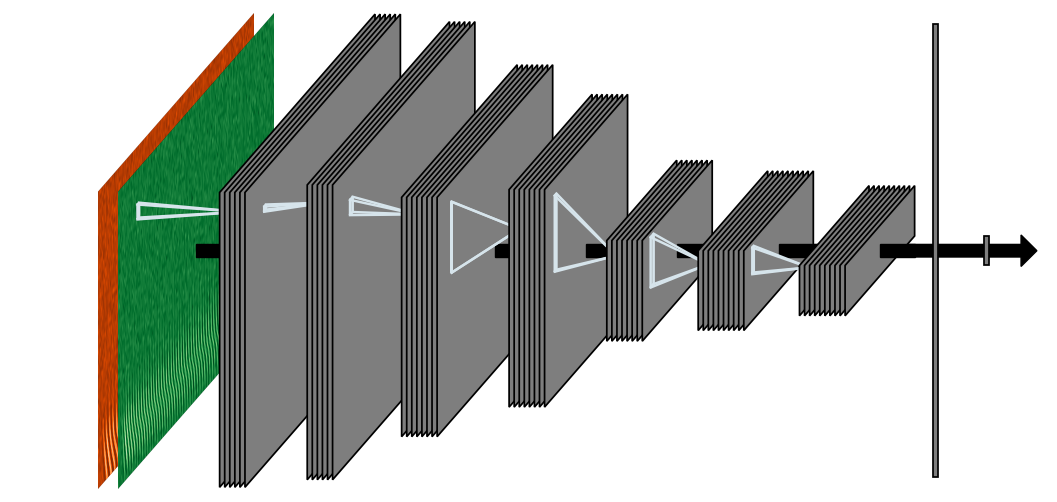

../figures_revision1/schematic_frequency_discrimination_network.pdf


In [49]:
input_image = np.transpose(y[0], axes=(1, 2, 0)).numpy()[..., ::-1]
input_image = input_image ** 0.3 # Increases contrast of colormaps
layer_list[-1]["shape_activation"] = [1.5] # Makes output layer more visible
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1, 1))
ax = util.draw_cnn_from_layer_list(
    ax,
    layer_list,
    input_image=input_image,
    binaural=True,
    kwargs_imshow_binaural=({"cmap": "Oranges_r"}, {"cmap": "Greens_r"}),
)
[xb, yb, dxb, dyb] = ax.dataLim.bounds
fig.set_size_inches(dxb / 3, dyb / 1.5)
plt.show()

fn = "../figures_revision1/schematic_frequency_discrimination_network.pdf"
fig.savefig(fn, bbox_inches="tight", pad_inches=0, transparent=True)
print(fn)


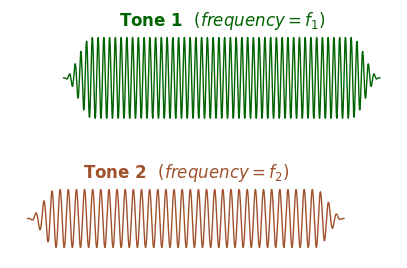

../figures_revision1/schematic_frequency_discrimination_stimuli.pdf


In [50]:
offset_t = 0.025
offset_y = 0.0125
x0 = x[0, :, 0].numpy()
x1 = x[0, :, 1].numpy()
t = np.arange(0, x0.shape[0]) / example["sr"].numpy()
IDX = t < 0.22
x0 = x0[IDX]
x1 = x1[IDX]
t = t[IDX]

color0 = "darkgreen"
color1 = "sienna"
kwargs_plot = {
    "marker": "",
    "lw": 1,
}
kwargs_text = {
    "ha": "center",
    "va": "bottom",
    "fontweight": "bold",
    "fontsize": 12,
}
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t + offset_t, x0 + offset_y, **kwargs_plot, color=color0)
ax.text(
    np.mean(t) + offset_t,
    x0.max() + offset_y + 0.0005,
    "Tone 1  $(frequency = f_1)$",
    **kwargs_text,
    color=color0,
)
ax.plot(t, x1, **kwargs_plot, color=color1)
ax.text(
    np.mean(t),
    x1.max() + 0.0005,
    "Tone 2  $(frequency = f_2)$",
    **kwargs_text,
    color=color1,
)
util.format_axes(
    ax,
    spines_to_hide=["top", "bottom", "left", "right"],
    xticks=[],
    yticks=[],
)
plt.show()

fn = "../figures_revision1/schematic_frequency_discrimination_stimuli.pdf"
fig.savefig(fn, bbox_inches="tight", pad_inches=0.05, transparent=True)
print(fn)


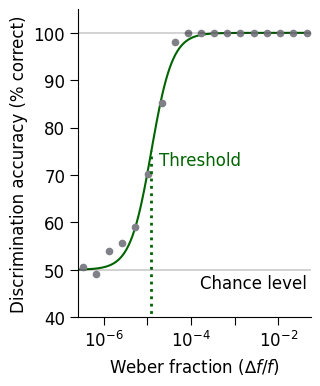

../figures_revision1/schematic_frequency_discrimination_psychometric_function.pdf


In [51]:
dir_model = "models/freq_quarter_octave/0250hz/IHC3000/arch_0346_00??"

list_fn_eval = [os.path.join(_, "eval.csv") for _ in glob.glob(dir_model)]
df = pd.concat([pd.read_csv(_) for _ in list_fn_eval])
df["correct"] = df["label"] == (df["logits"] > 0)
df["interval"] = np.abs(df["interval"])
df = (
    df.groupby(["f0", "interval"])
    .agg({"correct": "mean"})
    .reset_index()
)
df = df.sort_values(by=["f0", "interval"])
df = (
    df.groupby(["f0"])
    .agg({"interval": list, "correct": list})
    .reset_index()
)
kw = {"method": "dogbox", "max_nfev": 10000}
df["popt"] = df.apply(
    lambda _: util.fit_logistic_function(np.log(_["interval"]), _["correct"], **kw)[0],
    axis=1,
)
df["log_threshold"] = df["popt"].map(lambda _: util.logistic_function_inv(0.75, *_))
df["threshold"] = np.exp(df["log_threshold"])


def octave_to_weber_fraction(interval):
    return np.power(2, interval) - 1.0

fig, ax = plt.subplots(figsize=(3, 4))
color = "darkgreen"
dfi = df.iloc[0]
x = dfi.interval
y = 100 * np.array(dfi.correct)
threshold = octave_to_weber_fraction(dfi.threshold)
x_fit = np.exp(np.linspace(np.log(min(x) / 1.25), np.log(max(x) * 1.25), 250))
ax.plot(octave_to_weber_fraction(x_fit), 100 * util.logistic_function(np.log(x_fit), *dfi.popt), color=color, ls="-", lw=1.5)
ax.plot(octave_to_weber_fraction(x), y, marker="o", ms=4.5, color="#808088", ls="")
ax.plot([threshold, threshold], [0, 75], color=color, lw=2, ls=":")
ax.axhline(50, color="k", lw=0.25)
ax.axhline(100, color="k", lw=0.25)
ax.text(threshold * 1.5, 75, "Threshold", fontsize=12, color=color, va="top")
ax.text(octave_to_weber_fraction(x).max(), 49, "Chance level", fontsize=12, ha="right", va="top")
util.format_axes(
    ax,
    str_xlabel="Weber fraction ($∆f / f$)",
    str_ylabel="Discrimination accuracy (% correct)",
    ylimits=[40, 105],
    xlimits=[octave_to_weber_fraction(x).min() / 1.25, octave_to_weber_fraction(x).max() * 1.25],
    yticks=np.arange(40, 101, 10),
    xticks=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    xticklabels=["$10^{-6}$", "", "$10^{-4}$", "", "$10^{-2}$"],
    xscale="log",
    spines_to_hide=["top", "right"],
)
plt.show()

fn = "../figures_revision1/schematic_frequency_discrimination_psychometric_function.pdf"
fig.savefig(fn, bbox_inches="tight", pad_inches=0.05, transparent=True)
print(fn)
